# Quality Assessment Notebook for realism of quasar templates.

To-do for this notebook:
    - compute the EMPCA for mocks and data.
    - look the difference between the first eigenvectors for mocks and data.
    - look the difference between mean spectrum for data and mocks.
    - look the standard deviation for mocks and data from mean spectrum.
    
Conclusion:
    - What parameter do we need to change in SIMQSO?

In [1]:
from __future__ import absolute_import, division, print_function

import sys, os
import random
import optparse
import glob
import subprocess
import scipy as sp
import scipy.constants
from scipy import interpolate
import matplotlib.pyplot as plt
import fitsio
from astropy.io import fits

from empca import empca
from desispec.interpolation import resample_flux
%pylab inline
%matplotlib inline

Populating the interactive namespace from numpy and matplotlib


/global/common/software/desi/cori/desiconda/20180709-1.2.6-spec/conda/lib/python3.6/site-packages/IPython/core/magics/pylab.py:160: UserWarning: pylab import has clobbered these variables: ['random']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


The next lines are only if one work in a local branch.

In [2]:
os.environ['PYTHONPATH']='/global/cscratch1/sd/rodcn25/desi/code/desisim/py:'+os.environ['PYTHONPATH']
os.environ['PATH']='/global/cscratch1/sd/rodcn25/desi/code/desisim/bin/:'+os.environ['PATH']

## Mocks

Let me start by analysing the SIMQSO mocks for to make empca. Let's need to use the restframe from the SIMQSO.

In [3]:
from desisim.templates import SIMQSO
simqso = SIMQSO(restframe=True)

Let's choose 750 QSO spectra.

In [4]:
nqso = 750
seed = 123
tflux, twave, tmeta, tmag = simqso.make_templates(nqso, seed=seed, zrange=(2, 4))
dw = 0.1
wave = np.arange(600, 10000, dw)
mask=(twave>550) & (twave <2000)

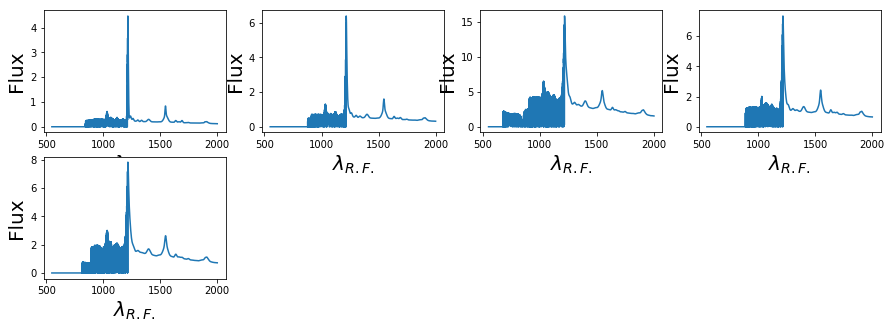

In [5]:
plt.figure(figsize=(15,13))
for i in range(nqso)[:5]:
    plt.subplot(5,4,i+1)
    flux=tflux[i]
    plt.plot(twave[mask],flux[mask])
    plt.xlabel('$\lambda_{R.F.}$',fontsize=20)
    plt.ylabel('Flux',fontsize=20)

In [6]:
qsoflux = np.zeros((nqso, wave.size))
for i in range(nqso):
    qsoflux[i] = resample_flux(wave, twave, tflux[i])

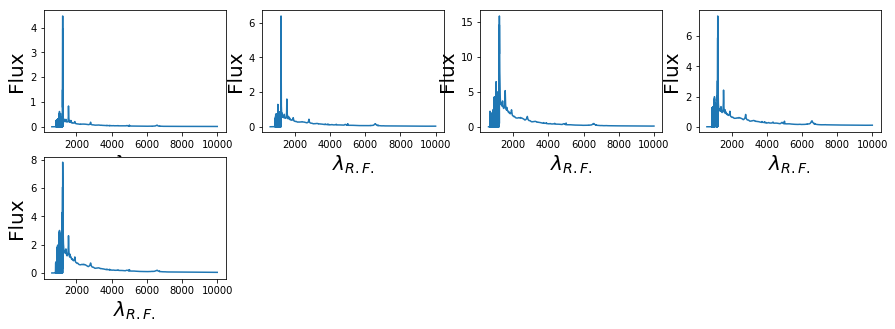

In [7]:
plt.figure(figsize=(15,13))
for i in range(nqso)[:5]:
    plt.subplot(5,4,i+1)
    #flux=tflux[i]
    plt.plot(wave,qsoflux[i])
    plt.xlabel('$\lambda_{R.F.}$',fontsize=20)
    plt.ylabel('Flux',fontsize=20)

Normalizing the spectra.

In [8]:
#qsofluxnor = []
msk = (wave>1230) & (wave<1600)
for i in range(qsoflux.shape[0]):
    qsoflux[i] /= np.mean(qsoflux[i][msk])

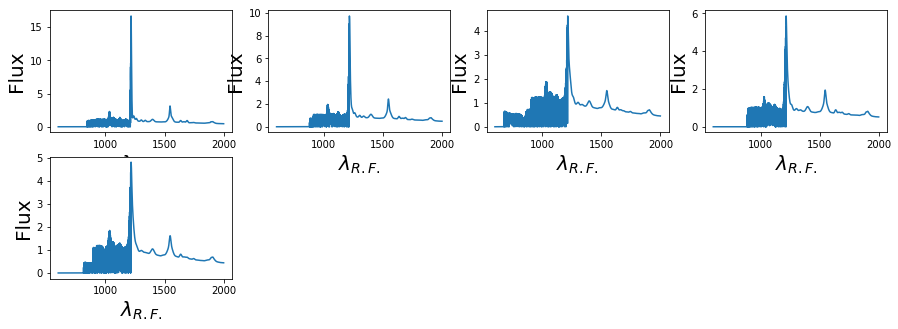

In [9]:
mska = (wave>550) & (wave<2000)
plt.figure(figsize=(15,13))
for i in range(nqso)[:5]:
    plt.subplot(5,4,i+1)
    qflux=qsoflux[i]
    plt.plot(wave[mska],qflux[mska])
    plt.xlabel('$\lambda_{R.F.}$',fontsize=20)
    plt.ylabel('Flux',fontsize=20)

Get the mean spectrum (stacking).

In [10]:
mock_meanspec = sp.average(qsoflux,axis=0) #It is the mean spectrum.

Get the standard deviation from mean.

In [72]:
std_mock = np.std(qsoflux,axis=0)

Then, I subtract the mean for each spectrum.

In [11]:
qsoflux -= mock_meanspec

Let's start the EMPCA for 15 eigenvector and 15 iterations.

In [22]:
model = empca.empca(qsoflux, niter=15, nvec=15)

       iter        R2             rchi2
EMPCA  1/15       0.00810313      0.01555733
EMPCA  2/15       0.41918638      0.00910973
EMPCA  3/15       0.56857183      0.00676670
EMPCA  4/15       0.58420910      0.00652144
EMPCA  5/15       0.58896170      0.00644690
EMPCA  6/15       0.59287290      0.00638556
EMPCA  7/15       0.59562062      0.00634246
EMPCA  8/15       0.59707654      0.00631962
EMPCA  9/15       0.59781643      0.00630802
EMPCA 10/15       0.59821618      0.00630175
EMPCA 11/15       0.59844872      0.00629810
EMPCA 12/15       0.59859300      0.00629584
EMPCA 13/15       0.59868761      0.00629436
EMPCA 14/15       0.59875288      0.00629333
EMPCA 15/15       0.59880032      0.00629259
R2: 0.59905282728


Normalizing coefficients for all inputs

In [23]:
for i in range(model.coeff.shape[0]):
    model.coeff[i] /= np.linalg.norm(model.coeff[i])

Save the data of the mocks

In [140]:
from astropy.table import Table,Column
colum_mock1 = [('wavelength','f8'),('mean spectrum','f8'),('std spectrum','f8')]
mocks1 = Table(np.zeros(len(wave),dtype=colum_mock1))
mocks1['wavelength'][:]=wave
mocks1['mean spectrum'][:]=mock_meanspec
mocks1['std spectrum'][:]=std_mock

colum_mock2=[('model continuum','f8'),('data spectra','f8'),('weights','f8')]
mocks2=Table(np.zeros((nqso,len(wave)),dtype=colum_mock2))
mocks2['model continuum'][:][:]=model.model
mocks2['data spectra'][:][:]=model.data
mocks2['weights'][:][:]=model.weights

colum_mock3=[('eigenvec','f8')]
mocks3=Table(np.zeros((model.eigvec.shape[0],model.eigvec.shape[1]),dtype=colum_mock3))
mocks3['eigenvec'][:][:]=model.eigvec

colum_mock4=[('coeff','f8')]
mocks4=Table(np.zeros((model.coeff.shape[0],model.coeff.shape[1]),dtype=colum_mock4))
mocks4['coeff'][:][:]=model.coeff

hmocks1 = fits.convenience.table_to_hdu(mocks1); hmocks1.name='mock_wl_mean_std'
hmocks2 = fits.convenience.table_to_hdu(mocks2); hmocks2.name='mock_model_data_weight'
hmocks3 = fits.convenience.table_to_hdu(mocks3); hmocks3.name='mock_eigenvectors'
hmocks4 = fits.convenience.table_to_hdu(mocks4); hmocks4.name='mock_coeff'

hdulist = fits.HDUList([fits.PrimaryHDU(),hmocks1,hmocks2,hmocks3,hmocks4])
hdulist.writeto('mocks_ground.fits', overwrite=True)

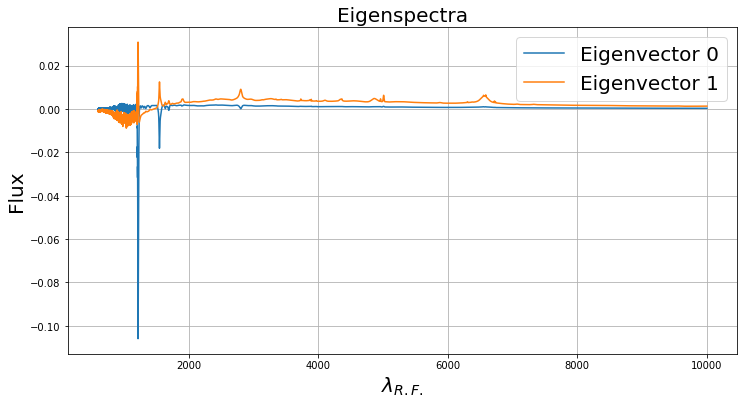

In [25]:
plt.figure(figsize=(12,6))
plt.title('Eigenspectra',fontsize=20)
pylab.plot(wave,model.eigvec[0], label='Eigenvector 0')
pylab.plot(wave,model.eigvec[1], label='Eigenvector 1')
#pylab.plot(model.eigvec[2], label='3 Eigenvector')
plt.xlabel('$\lambda_{R.F.}$', fontsize = 20)
plt.ylabel('Flux', fontsize = 20) 
#plt.xlim(750,2500)
plt.grid()
plt.legend(fontsize=20)

The eigenvector 0 is negative due to the subtraction of the mean spectrum.

## Now, for the data of BOSS DR14.

In [26]:
# Lyman-alpha from eqn 5 of Calura et al. 2012 (Arxiv: 1201.5121)
# Other from eqn 1.1 of Irsic et al. 2013 , (Arxiv: 1307.3403)
# Lyman-limit from abstract of Worseck et al. 2014 (Arxiv: 1402.4154)
Lyman_series = {
    'Lya'     : { 'line':1215.67,  'A':0.0023,          'B':3.64, 'var_evol':3.8 },
    'Lyb'     : { 'line':1025.72,  'A':0.0023/5.2615,   'B':3.64, 'var_evol':3.8 },
    'Ly3'     : { 'line':972.537,  'A':0.0023/14.356,   'B':3.64, 'var_evol':3.8 },
    'Ly4'     : { 'line':949.7431, 'A':0.0023/29.85984, 'B':3.64, 'var_evol':3.8 },
    'Ly5'     : { 'line':937.8035, 'A':0.0023/53.36202, 'B':3.64, 'var_evol':3.8 },
    #'LyLimit' : { 'line':911.8,    'A':0.0023,          'B':3.64, 'var_evol':3.8 },
}

In [27]:
def transmission_Lyman(zObj,lObs):
    '''Calculate the transmitted flux fraction from the Lyman series
    This returns the transmitted flux fraction:
        1 -> everything is transmitted (medium is transparent)
        0 -> nothing is transmitted (medium is opaque)
    Args:
        zObj (float): Redshift of object
        lObs (array of float): wavelength grid
    Returns:
        array of float: transmitted flux fraction
    '''

    lRF = lObs/(1.+zObj)
    T   = sp.ones(lObs.size)

    for l in list(Lyman_series.keys()):
        w      = lRF<Lyman_series[l]['line']
        zpix   = lObs[w]/Lyman_series[l]['line']-1.
        tauEff = Lyman_series[l]['A']*(1.+zpix)**Lyman_series[l]['B']
        T[w]  *= sp.exp(-tauEff)

    return T

Choose only the QSO's

In [28]:
def plot_spplate(path_to_data,plate,mjd,fiber):

    ###
    path = path_to_data+str(plate)+'/spPlate-' +str(plate)+'-'+str(mjd)+'.fits'

    cat = fitsio.FITS(path)
    psflux = cat[0].read()
    psivar = cat[1].read()
    end  = cat[2].read()
    h    = cat[4].read_header()
    fid = cat[5].read()
    cat.close()

    pswave = h['CRVAL1'] + h['CD1_1']*sp.arange(h['NAXIS1'])
    if h['DC-FLAG']:
        pswave = 10**pswave

    ###
    cut = (psivar[fiber-1,:]>0.) & (end[fiber-1,:]==0)
    qsoid = np.where(fid['OBJTYPE'][:] == b'QSO             ')[0] #I only choose the QSO's. 
    if (fiber-1) in qsoid:
        pswave = pswave[cut]
        psflux = psflux[fiber-1,:][cut]
        psivar = psivar[fiber-1,:][cut]
    else: 
        #print('No QSO')
        pswave = np.array([0])
        psflux = np.array([0])
        psivar = np.array([0])

    return pswave, psflux, psivar

In [29]:
def lines_list(path):

    lines = []
    fileLines = open(path)
    for l in fileLines:
        l = l.split()
        if l[0]=='#': continue
        lines += [ [float(l[1]),float(l[2])] ]
    fileLines.close()
    lines = sp.asarray(lines)

    return lines

In [32]:
def get_pca():

    ### Parameters
    path_spec      = '/project/projectdirs/cosmo/data/sdss/dr14/eboss/spectro/redux/v5_10_0/'
    path_drq       = '/global/cscratch1/sd/rodcn25/lya/boss_data/DR14Q_v4_4.fits'
    path_lines     = '/global/homes/r/rodcn25/PCA/dr14-line-sky-mask.txt'
    nbObj  = 10000
    CRVAL1 = 2.6534
    CDELT1 = 0.0001
    NBLL   = 13637

    ### Get lines to veto
    lines = lines_list(path_lines)

    ### Get list qso
    data      = fitsio.FITS(path_drq)
    w  = sp.ones(data[1]['PLATE'][:].size).astype(bool)
    print('INFO: init              : ', w.sum())
    w &= data[1]['THING_ID'][:]>0.
    print('INFO: removed THID>=0   : ', w.sum())
    #print('INFO: removed THID<=0   : ', w.sum())
    w &= data[1]['Z_PCA'][:]>0.
    print('INFO: removed zvi>=0.   : ', w.sum())
    #print('INFO: removed zvi<=0.   : ', w.sum())
    plate   = data[1]['PLATE'][:][w]
    mjd     = data[1]['MJD'][:][w]
    fiberid = data[1]['FIBERID'][:][w]
    zvi     = data[1]['Z_PCA'][:][w]
    data.close()
    nsamples=100
    ### Random number of object
    sp.random.seed(10)
    listQSO = sp.arange(plate.size)
    randSelec = sp.array([])
    for i in sp.arange(0.,10.,0.1):
        w = (zvi>=i) & (zvi<i+0.1)
        if listQSO[w].size==0: continue
        r = sp.random.choice(listQSO[w], size=min(listQSO[w].size,nsamples), replace=False)
        randSelec = sp.append(randSelec,r)
    #randSelec = sp.append(randSelec,sp.random.choice(listQSO, size=nbObj, replace=False))
    randSelec = sp.unique(randSelec)
    randSelec = randSelec.astype(int)
    nbObj = randSelec.size
    print('INFO: size = ', nbObj)


    ### Get spectra
    ttwave = []
    ttflux = []
    ttivar = []
    for i in range(nbObj)[:900]: 
        #if i%10==0: print(i)
        r = randSelec[i]

        TMPwave, TMPflux, TMPivar = plot_spplate(path_spec,plate=plate[r],mjd=mjd[r],fiber=fiberid[r])
        TMPwaveRF = TMPwave/(1.+zvi[r])
        if TMPwave.size<500:
            #print('INFO: removing size<10: {}'.format(TMPwave.size))
            continue

        ### Remove sky lines and CCD edge
        w = sp.ones_like(TMPwave).astype(bool)
        for l in lines:
            w &= (TMPwave<l[0]) | (TMPwave>l[1])
        w &= TMPwave>3600.
        w &= TMPwave<7235.
        TMPwave = TMPwave[w]
        TMPflux = TMPflux[w]
        TMPivar = TMPivar[w]
        TMPwaveRF = TMPwaveRF[w]
        if TMPwave.size<500:
            #print('INFO: removing size<10: {}'.format(TMPwave.size))
            continue

        ### Correct for Lyman
        T = transmission_Lyman(zvi[r],TMPwave)
        TMPflux /= T
        TMPivar *= T**2

        ### Rescale by median
        mid = sp.median(TMPflux)
        if mid<=0.:
            #print('INFO: removing med<=0: {}'.format(mid))
            continue
        TMPflux /= mid
        TMPivar *= mid**2

        ### Store
        ttwave += [TMPwaveRF]
        ttflux += [TMPflux]
        ttivar += [TMPivar]
        
    rwave = []
    rflux = []
    rivar = []
    for j in range(len(ttflux)):
        if ttwave[j].any() and ttflux[j].any() == False:
            continue
        elif ttwave[j].any() and ttflux[j].any() == True:
            rwave += [ttwave[j]]
            rflux += [ttflux[j]]
            rivar += [ttivar[j]]

    nbObj = len(rwave)
    print('INFO: size = ', nbObj)

    ###
    pcawave    = 10**(CRVAL1+sp.arange(NBLL)*CDELT1)
    pcaflux    = sp.zeros((nbObj, pcawave.size))
    pcaivar    = sp.zeros((nbObj, pcawave.size))
    ### On same grid
    for i in range(nbObj):
        pcaflux[i],pcaivar[i] = resample_flux(pcawave, rwave[i], rflux[i], rivar[i])
    pcaivar[pcaivar<0.] = 0.
    ### Remove if all measured bins are zero
    w    = sp.sum(pcaivar,axis=0)>0.
    pcawave = pcawave[w]
    pcaflux = pcaflux[:,w]
    pcaivar = pcaivar[:,w]
    ### Cap the ivar
    pcaivar[pcaivar>100.] = 100.

    ### Get the mean
    data_meanspec = sp.average(pcaflux,weights=pcaivar,axis=0) # Here, I get the mean spectrum (stacking).
    for i in range(nbObj):       #
        w = pcaivar[i]>0.        # subtracting the mean for each spectrum
        pcaflux[i,w] -= data_meanspec[w] #

    ### PCA
    print('INFO: Starting PCA')
    dmodel = empca.empca(pcaflux, weights=pcaivar, niter=15, nvec=15)
    for i in range(dmodel.coeff.shape[0]):
        dmodel.coeff[i] /= sp.linalg.norm(dmodel.coeff[i])
        
    return dmodel, pcawave, pcaflux, pcaivar, data_meanspec

In [33]:
model_empca, wave_empca, flux_empca, ivar_empca, meanspec_data=get_pca()

INFO: init              :  526356
INFO: removed THID>=0   :  446137
INFO: removed zvi>=0.   :  444976
INFO: size =  4801
INFO: size =  679
INFO: Starting PCA
       iter        R2             rchi2
EMPCA  1/15       0.03971632      3.38586885
EMPCA  2/15       0.28521288      2.14395048
EMPCA  3/15       0.44409366      1.60529499
EMPCA  4/15       0.48987825      1.50540502
EMPCA  5/15       0.48169861      1.76377721
EMPCA  6/15       0.45167356      1.92471095
EMPCA  7/15       0.47682626      1.44289156
EMPCA  8/15       0.50713266      1.19520004
EMPCA  9/15       0.51436382      1.15025542
EMPCA 10/15       0.51345670      1.19741214
EMPCA 11/15       0.51779031      1.15704742
EMPCA 12/15       0.51784697      1.17589073
EMPCA 13/15       0.51446420      1.24823837
EMPCA 14/15       0.51068438      1.25625762
EMPCA 15/15       0.51745867      1.26265224
R2: 0.530368543416


Get the standard deviation for DR14.

In [73]:
std_data = np.std(flux_empca,axis=0)

Save data

In [141]:
colum_data1 = [('wavelength','f8'),('mean spectrum','f8'),('std spectrum','f8')]
data1 = Table(np.zeros(len(wave_empca),dtype=colum_data1))
data1['wavelength'][:]=wave_empca
data1['mean spectrum'][:]=meanspec_data
data1['std spectrum'][:]=std_data

colum_data2=[('model continuum','f8'),('data spectra','f8'),('weights','f8')]
data2=Table(np.zeros((model_empca.data.shape[0],len(wave_empca)),dtype=colum_data2))
data2['model continuum'][:][:]=model_empca.model
data2['data spectra'][:][:]=model_empca.data
data2['weights'][:][:]=model_empca.weights

colum_data3=[('eigenvec','f8')]
data3=Table(np.zeros((model_empca.eigvec.shape[0],model_empca.eigvec.shape[1]),dtype=colum_data3))
data3['eigenvec'][:][:]=model_empca.eigvec

colum_data4=[('coeff','f8')]
data4=Table(np.zeros((model_empca.coeff.shape[0],model_empca.coeff.shape[1]),dtype=colum_data4))
data4['coeff'][:][:]=model_empca.coeff

hdata1 = fits.convenience.table_to_hdu(data1); hdata1.name='data_wl_mean_std'
hdata2 = fits.convenience.table_to_hdu(data2); hdata2.name='data_model_data_weight'
hdata3 = fits.convenience.table_to_hdu(data3); hdata3.name='data_eigenvectors'
hdata4 = fits.convenience.table_to_hdu(data4); hdata4.name='data_coeff'

hdulist = fits.HDUList([fits.PrimaryHDU(),hdata1,hdata2,hdata3,hdata4])
hdulist.writeto('data_ground.fits', overwrite=True)

Let's start looking the spectra that were taken. 

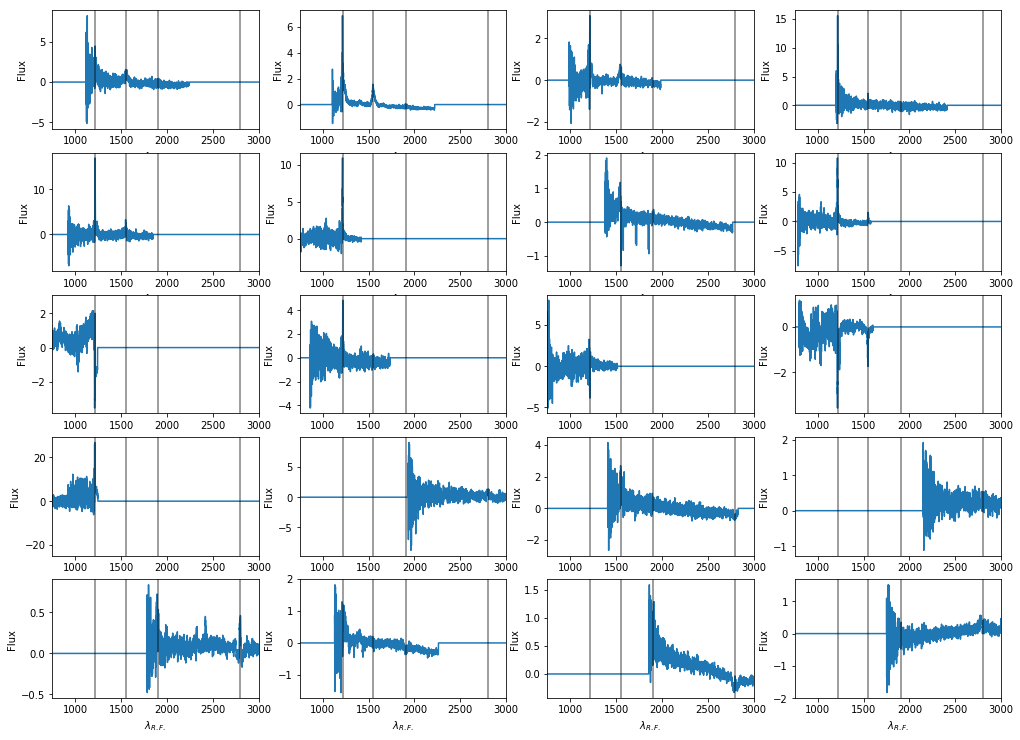

In [34]:
plt.figure(figsize=(17,65))
for i in range(len(flux_empca))[20:40]:
    plt.subplot(25,4,i+1)
    plt.plot(wave_empca,flux_empca[i])
    axvline(1216,color='k',alpha=0.5) # I choose the point of Ly-alpha peak.
    axvline(1549,color='k',alpha=0.5)
    axvline(1906,color='k',alpha=0.5)
    axvline(2800,color='k',alpha=0.5)
    plt.xlabel('$\lambda_{R.F.}$', fontsize = 10)
    plt.ylabel('Flux', fontsize = 10)    
    plt.xlim(750,3000)

# Comparing the mean spectrum between mocks and data and the standard deviation.

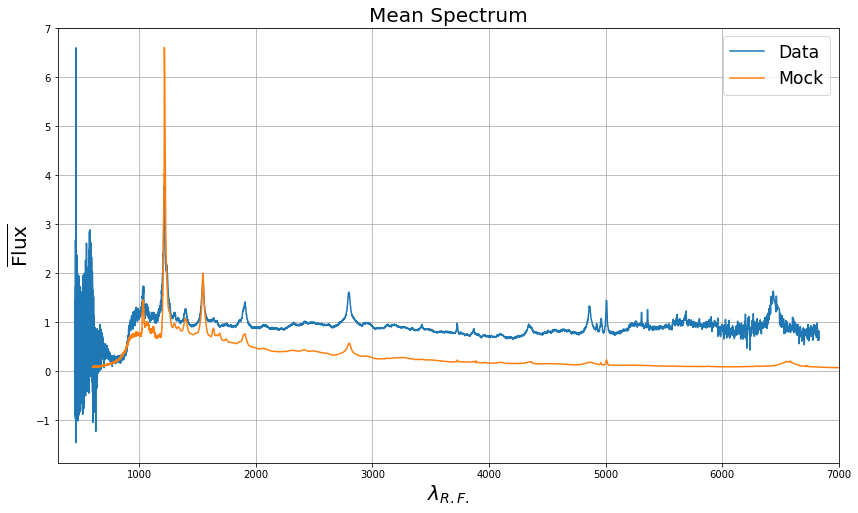

In [160]:
plt.figure(figsize=(14,8))
plt.title('Mean Spectrum',fontsize=20)
plt.plot(wave_empca,meanspec_data,label='Data')
plt.plot(wave,mock_meanspec,label='Mock')
#axvline(1216,color='k',alpha=0.5) # I choose the point of Ly-alpha peak.
#axvline(1549,color='k',alpha=0.5)
#axvline(1906,color='k',alpha=0.5)
#axvline(2800,color='k',alpha=0.5)
plt.xlim(300,7000)
plt.xlabel('$\lambda_{R.F.}$', fontsize = 20)
plt.ylabel('$\mathrm{\overline{Flux}}$', fontsize = 20)
plt.legend(fontsize='xx-large')
plt.grid()

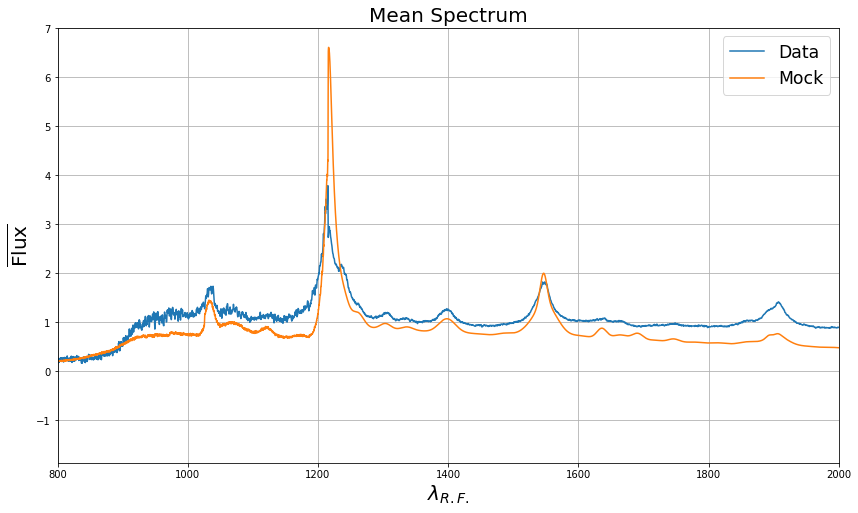

In [159]:
plt.figure(figsize=(14,8))
plt.title('Mean Spectrum',fontsize=20)
plt.plot(wave_empca,meanspec_data,label='Data')
plt.plot(wave,mock_meanspec,label='Mock')
#axvline(1216,color='k',alpha=0.5) # I choose the point of Ly-alpha peak.
#axvline(1549,color='k',alpha=0.5)
#axvline(1906,color='k',alpha=0.5)
#axvline(2800,color='k',alpha=0.5)
plt.xlabel('$\lambda_{R.F.}$', fontsize = 20)
plt.ylabel('$\mathrm{\overline{Flux}}$', fontsize = 20)
plt.xlim(800,2000)
plt.legend(fontsize='xx-large')
plt.grid()

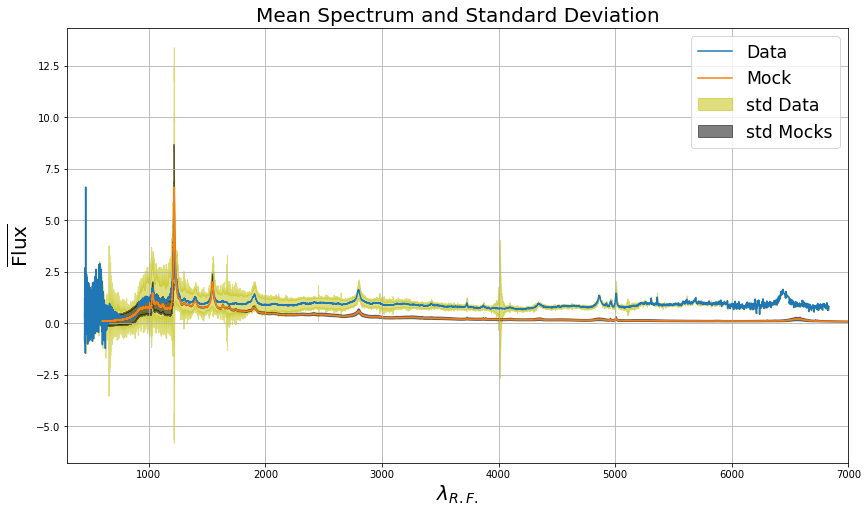

In [145]:
plt.figure(figsize=(14,8))
plt.title('Mean Spectrum and Standard Deviation',fontsize=20)
plt.plot(wave_empca,meanspec_data,label='Data')
plt.fill_between(wave_empca,meanspec_data+std_data, meanspec_data-std_data, label='std Data', color = 'y', alpha=0.5)
plt.plot(wave,mock_meanspec,label='Mock')
plt.fill_between(wave,mock_meanspec+std_mock, mock_meanspec-std_mock, label='std Mocks', color = 'k', alpha=0.5)
plt.xlim(300,7000)
plt.xlabel('$\lambda_{R.F.}$', fontsize = 20)
plt.ylabel('$\mathrm{\overline{Flux}}$', fontsize = 20)
plt.legend(fontsize='xx-large')
plt.grid()

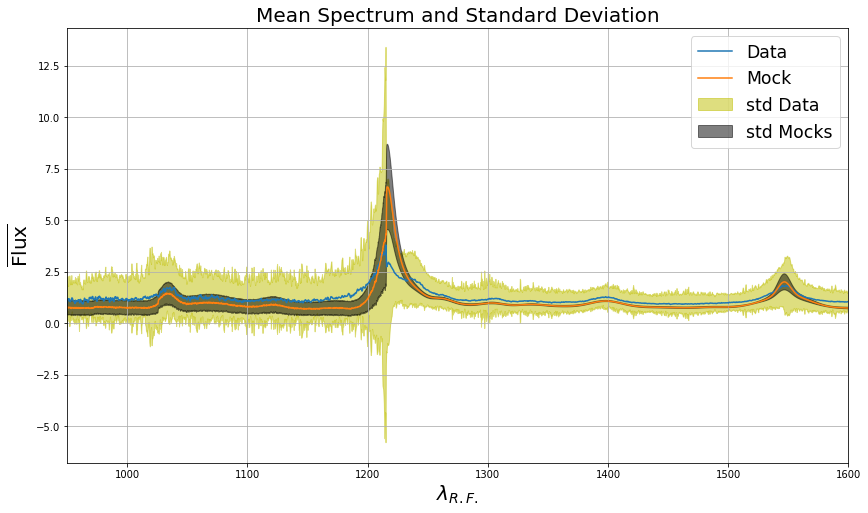

In [147]:
plt.figure(figsize=(14,8))
plt.title('Mean Spectrum and Standard Deviation',fontsize=20)
plt.plot(wave_empca,meanspec_data,label='Data')
plt.fill_between(wave_empca,meanspec_data+std_data, meanspec_data-std_data, label='std Data', color = 'y', alpha=0.5)
plt.plot(wave,mock_meanspec,label='Mock')
plt.fill_between(wave,mock_meanspec+std_mock, mock_meanspec-std_mock, label='std Mocks', color = 'k', alpha=0.5)
plt.xlim(950,1600)
plt.xlabel('$\lambda_{R.F.}$', fontsize = 20)
plt.ylabel('$\mathrm{\overline{Flux}}$', fontsize = 20)
plt.legend(fontsize='xx-large')
plt.grid()

## Let's compare the eigenvectors between mocks and BOSS DR14 data.

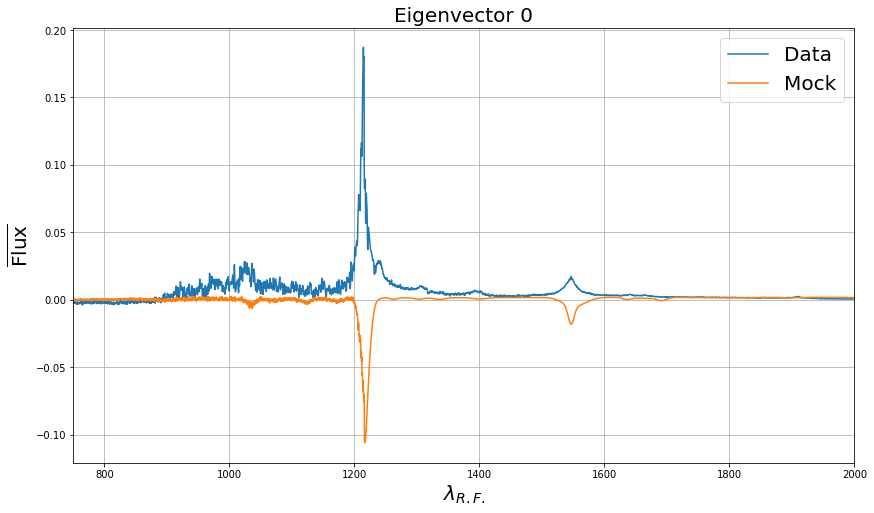

In [71]:
plt.figure(figsize=(14,8))
plt.title('Eigenvector 0',fontsize=20)
pylab.plot(wave_empca,model_empca.eigvec[0],label='Data')
pylab.plot(wave,model.eigvec[0], label='Mock')
#axvline(1216,color='k', label='Lya peak', alpha=0.7)
plt.xlim(750,2000)
#plt.ylim(-2.5,10)
plt.xlabel('$\lambda_{R.F.}$', fontsize = 20)
plt.ylabel('$\mathrm{\overline{Flux}}$', fontsize = 20)
plt.grid()
plt.legend(fontsize = 20)
plt.savefig('eigenspectra0_MD')

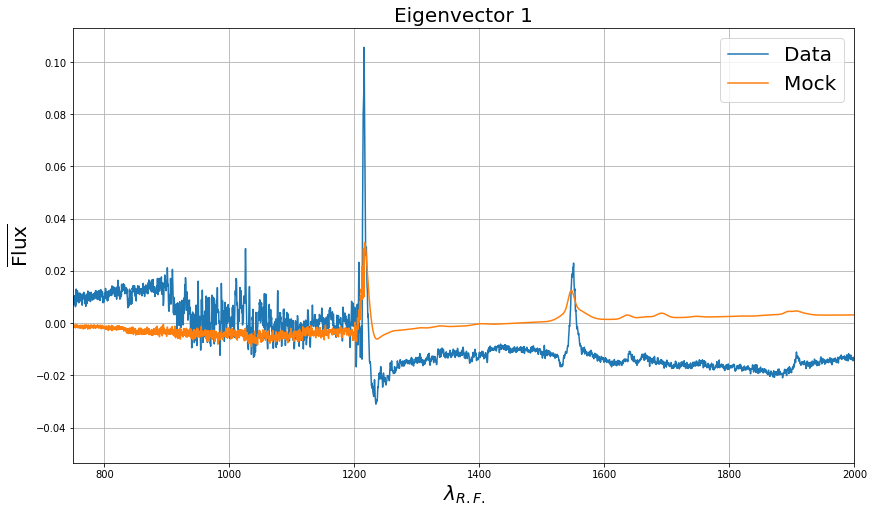

In [68]:
plt.figure(figsize=(14,8))
plt.title('Eigenvector 1',fontsize=20)
pylab.plot(wave_empca,model_empca.eigvec[1],label='Data')
pylab.plot(wave,model.eigvec[1], label='Mock')
#axvline(1216,color='k',alpha=0.5)
plt.xlim(750,2000)
#plt.ylim(-2.5,10)
plt.xlabel('$\lambda_{R.F.}$', fontsize = 20)
plt.ylabel('$\mathrm{\overline{Flux}}$', fontsize = 20)
plt.grid()
plt.legend(fontsize = 20)
plt.savefig('eigenspectra1_MD')

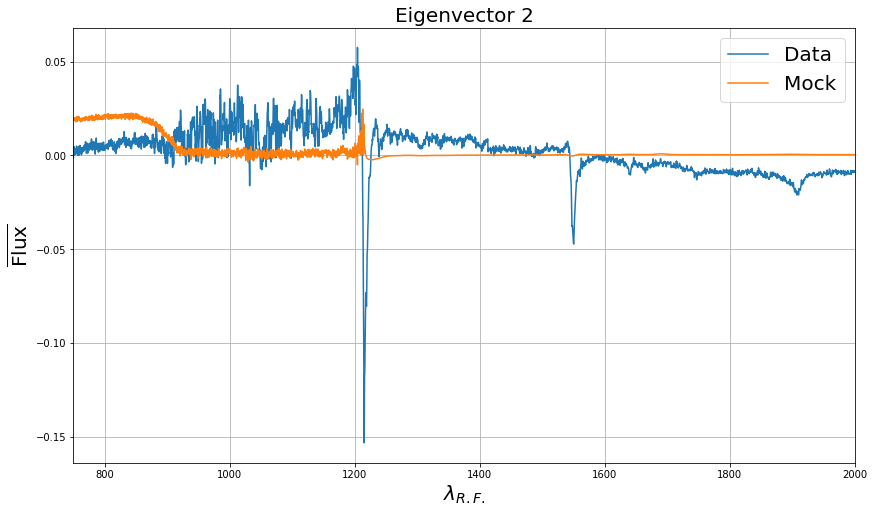

In [70]:
plt.figure(figsize=(14,8))
plt.title('Eigenvector 2',fontsize=20)
pylab.plot(wave_empca,model_empca.eigvec[2],label='Data')
pylab.plot(wave,model.eigvec[2], label='Mock')
#axvline(1216,color='k',alpha=0.5)
plt.xlim(750,2000)
#plt.ylim(-2.5,10)
plt.xlabel('$\lambda_{R.F.}$', fontsize = 20)
plt.ylabel('$\mathrm{\overline{Flux}}$', fontsize = 20)
plt.grid()
plt.legend(fontsize = 20)
plt.savefig('eigenspectra2_MD')

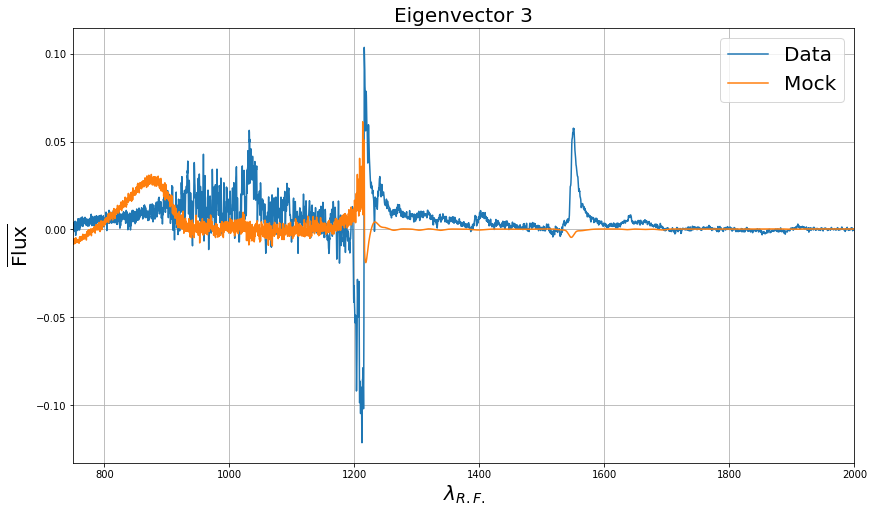

In [69]:
plt.figure(figsize=(14,8))
plt.title('Eigenvector 3',fontsize=20)
pylab.plot(wave_empca,model_empca.eigvec[3],label='Data')
pylab.plot(wave,model.eigvec[3], label='Mock')
#axvline(1216,color='k',alpha=0.5)
plt.xlim(750,2000)
#plt.ylim(-2.5,10)
plt.xlabel('$\lambda_{R.F.}$', fontsize = 20)
plt.ylabel('$\mathrm{\overline{Flux}}$', fontsize = 20)
plt.grid()
plt.legend(fontsize = 20)
plt.savefig('eigenspectra3_MD')